In [1]:
cd ../../

/Users/ChesterHuynh/OneDrive - Johns Hopkins/research/motor-decoding


In [2]:
import json
import sys
from collections import Counter
from itertools import cycle
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import mne
import numpy as np
import pandas as pd

from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne_bids.read import read_raw_bids
from mne_bids import BIDSPath
# from rerf.rerfClassifier import rerfClassifier
from scipy.io import loadmat
from scipy.spatial.distance import euclidean
from scipy import stats
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, label_binarize
from tqdm import tqdm

from mtsmorf.io.read import read_dataset, read_label, read_trial, get_trial_info
from mtsmorf.io.utils import NumpyEncoder
from mtsmorf.war_exp.cv import nested_cv_fit, cv_fit, bootstrap_fit

from mtsmorf.move_exp.plotting import (
    plot_signals,
    plot_roc_multiclass_cv,
    plot_feature_importances,
    plot_cv_indices
)

# plt.style.use(['science', 'ieee', 'no-latex'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
def plot_epochs(epochs, labels, picks=None):

    drop_inds = {k : np.where(labels != k)[0] for k in np.unique(labels)}
    label_names = {0: "Down", 1: "Right", 2: "Up", 3: "Left"}

    epochs_by_direction = {}
    for k, v in drop_inds.items():
        tmp = epochs.copy()
        tmp.drop(v)
        epochs_by_direction[k] = tmp

    for k, ep in epochs_by_direction.items():
        fig = ep.plot(
            picks=picks,
            scalings=dict(seeg=1e2), 
            n_epochs=5,
            show=False,
            title=label_names[k],
        )
        fig.suptitle(label_names[k])
        fig.set_size_inches(18, 4, forward=True)
        plt.show()

    for i, (k, ep) in enumerate(epochs_by_direction.items()):
        ep.plot_image(
            picks=picks,
            scalings=dict(seeg=1e-6),
            title=f"{label_names[k]}: {picks}"
        )

## EFRI14

In [4]:
bids_root = Path("/Volumes/mac/research/data/efri/")
# bids_root = Path("/workspaces/research/mnt/data/efri")
derivatives_path = (
    bids_root / "derivatives" / "preprocessed" / "low-pass=1000Hz-downsample=500"
)

# subject identifiers
subject = "efri14"
session = "efri"
task = "move"
acquisition = "seeg"
run = "01"
kind = "ieeg"

bids_path = BIDSPath(subject=subject, session=session, task=task,
                     acquisition=acquisition, run=run, suffix=kind, extension=".vhdr", root=bids_root)

In [5]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

# set time window
# tmin, tmax = (-0.5, 1.0)
tmin, tmax = (-0.75, 1.25)

# get EEG data
picks = []
epochs = read_dataset(
    bids_path,
    tmin=tmin,
    tmax=tmax,
    picks=picks,
    event_key="Left Target",
    notch_filter=True,
)

epochs.drop(unsuccessful_trial_inds)

epochs.load_data()

# Low-pass filter up to sfreq/2
fs = epochs.info["sfreq"]
epochs = epochs.filter(l_freq=None, h_freq=fs / 2 - 1)

# Downsample epochs to 500 Hz
resample_rate = 500
epochs = epochs.resample(resample_rate)

Out of 163 trials, there were 154 successful trials in /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 163 trials, there were 154 successful trials in /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Extracting parameters from /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 163 trials, there were 154 successful trials in /Volumes/mac/research/data/efri/sub-efri14/ses-efri/ieeg/sub-efri14_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading 0 ... 3773999  =      0.000 ..

Dropped 96 epochs: 0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 21, 22, 24, 25, 26, 27, 28, 32, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 92, 94, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 126, 127
Dropped 98 epochs: 0, 1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 68, 70, 71, 73, 74, 76, 77, 78, 79, 81, 83, 84, 86, 90, 91, 92, 93, 95, 96, 97, 98, 102, 103, 104, 105, 106, 107, 108, 111, 113, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127
Dropped 93 epochs: 1, 2, 3, 4, 5, 7, 9, 10, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 37, 41, 42, 44, 45, 46, 49, 52, 54, 56, 5

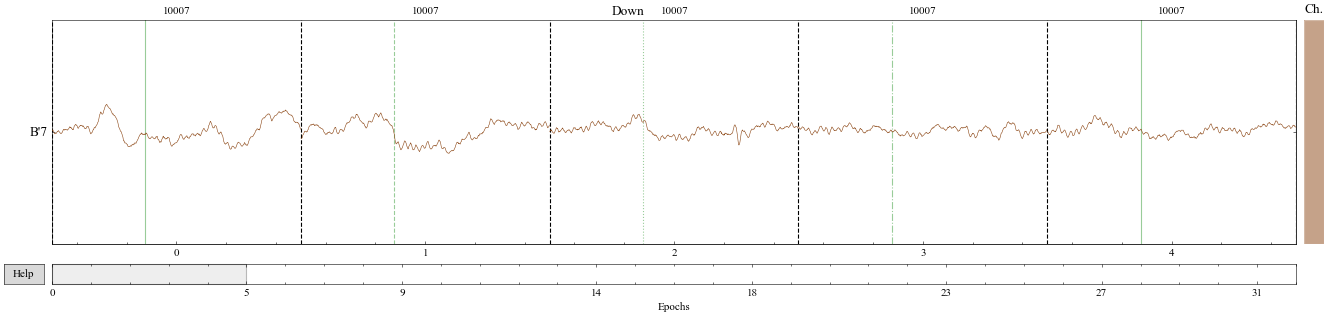

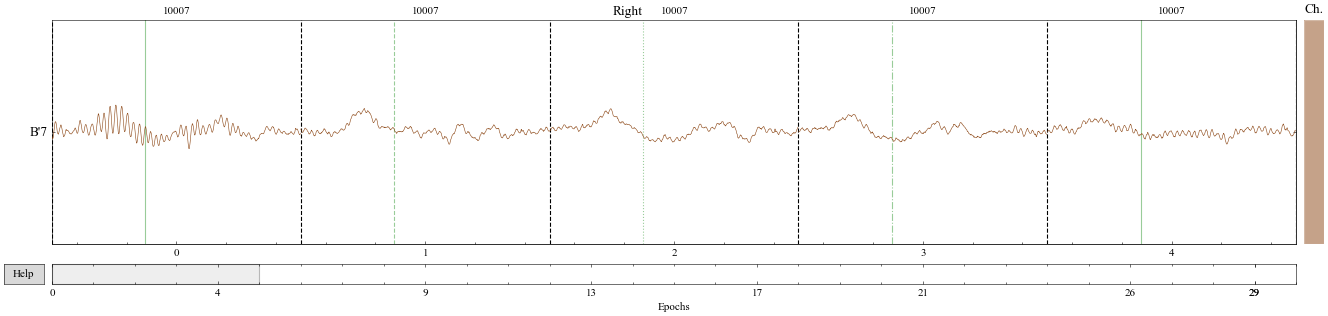

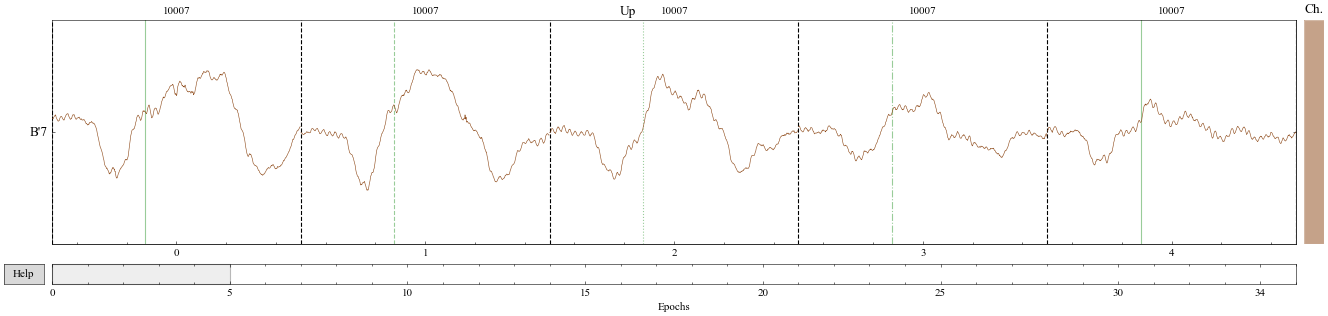

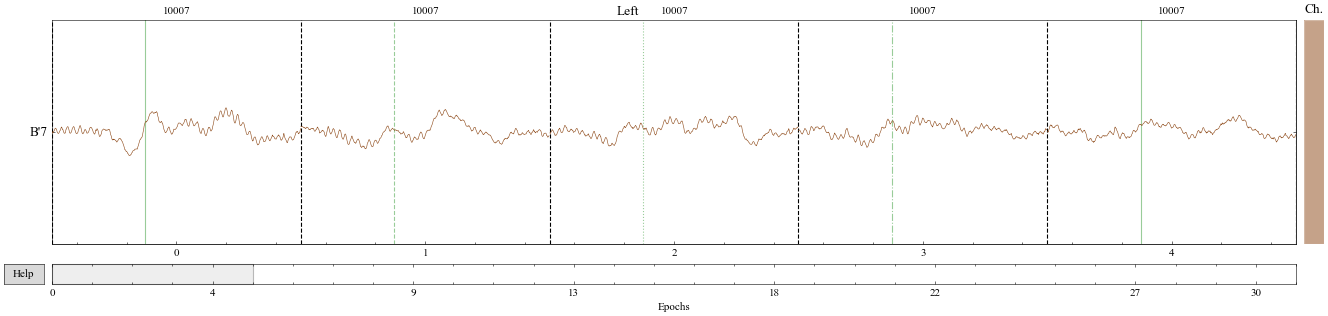

Not setting metadata
Not setting metadata
32 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


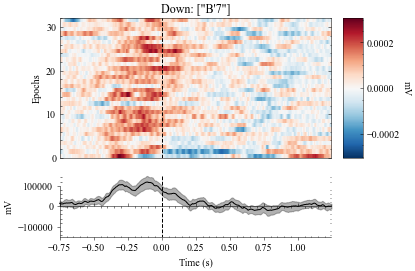

Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


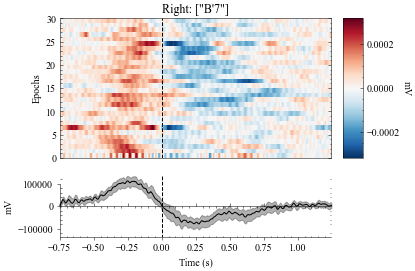

Not setting metadata
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


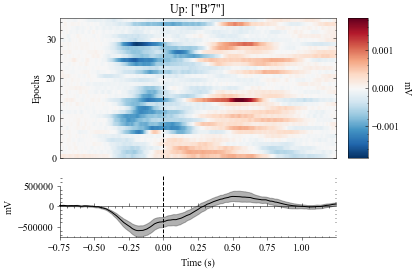

Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


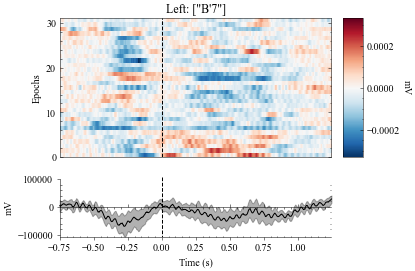

In [6]:
picks = ["B'7"]
plot_epochs(epochs, labels, picks=picks)

## EFRI02

In [7]:
bids_path.subject = "efri02"
bids_path

BIDSPath(
root: /Volumes/mac/research/data/efri
datatype: ieeg
basename: sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr)

In [8]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

# set time window
# tmin, tmax = (-0.5, 1.0)
tmin, tmax = (-0.75, 1.25)

# get EEG data
picks = []
epochs = read_dataset(
    bids_path,
    tmin=tmin,
    tmax=tmax,
    picks=picks,
    event_key="Left Target",
    notch_filter=True,
)

epochs.drop(unsuccessful_trial_inds)

epochs.load_data()

# Low-pass filter up to sfreq/2
fs = epochs.info["sfreq"]
epochs = epochs.filter(l_freq=None, h_freq=fs / 2 - 1)

# Downsample epochs to 500 Hz
resample_rate = 500
epochs = epochs.resample(resample_rate)

Out of 135 trials, there were 132 successful trials in /Volumes/mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 135 trials, there were 132 successful trials in /Volumes/mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Extracting parameters from /Volumes/mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 135 trials, there were 132 successful trials in /Volumes/mac/research/data/efri/sub-efri02/ses-efri/ieeg/sub-efri02_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading 0 ... 9875999  =      0.000 ..

Dropped 74 epochs: 0, 3, 5, 6, 7, 8, 10, 11, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 29, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 70, 71, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 88, 90, 92, 96, 97, 99, 101, 103
Dropped 82 epochs: 0, 1, 2, 4, 6, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 44, 45, 46, 47, 49, 51, 52, 53, 54, 55, 56, 59, 60, 61, 63, 65, 66, 67, 68, 69, 71, 72, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104
Dropped 80 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 18, 19, 20, 22, 23, 26, 27, 28, 30, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 51, 53, 54, 55, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 72, 73, 76, 77, 80, 82, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104
Dropped 79 epo

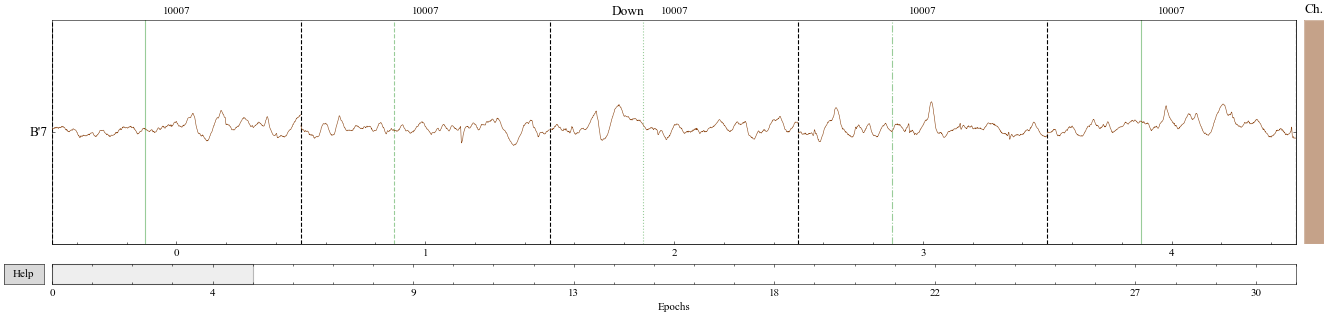

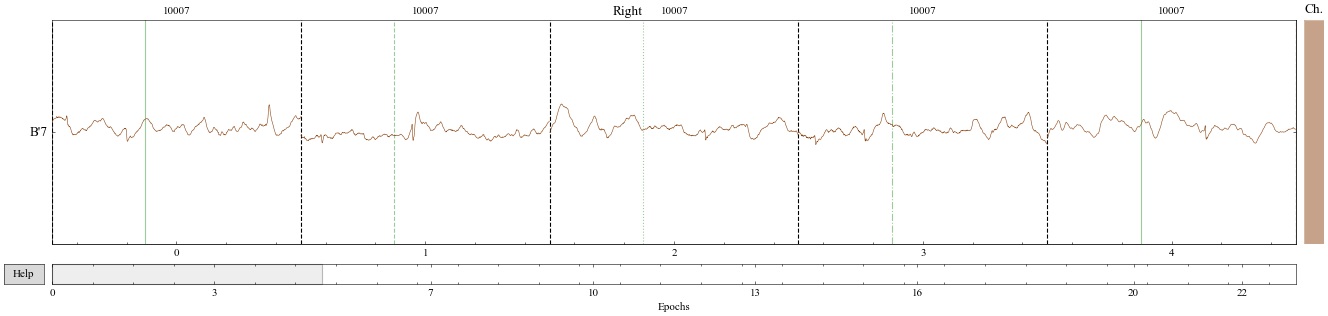

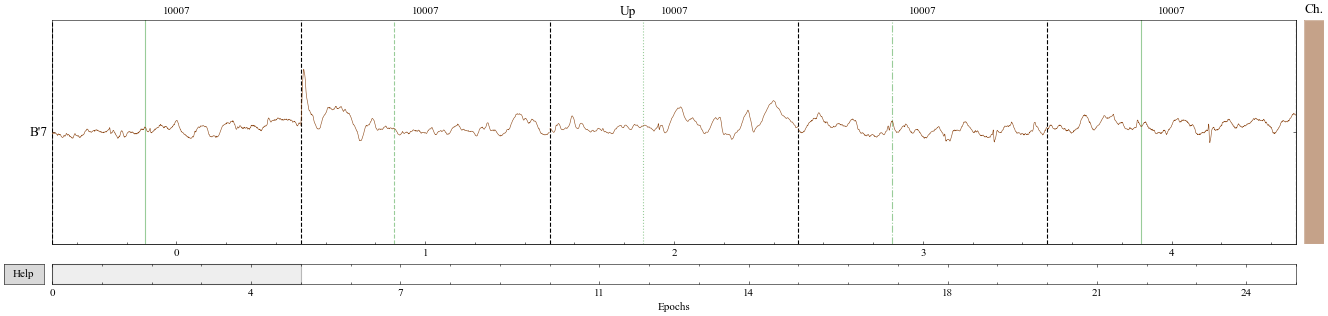

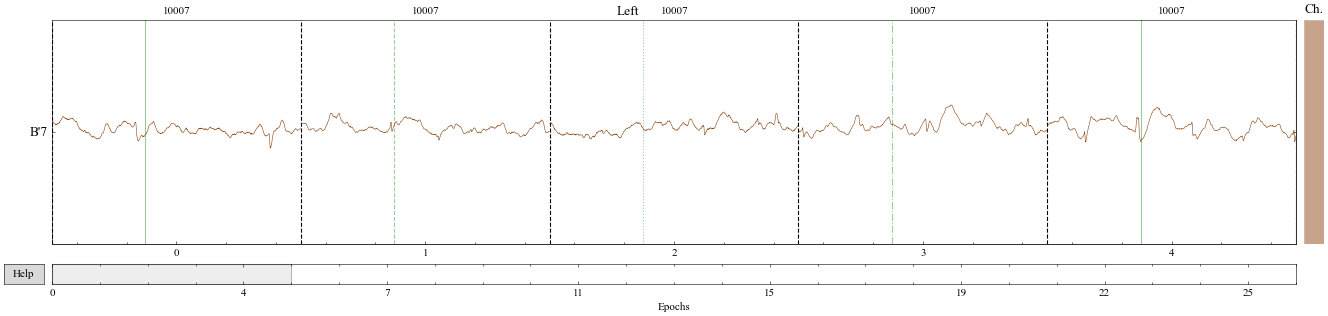

Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


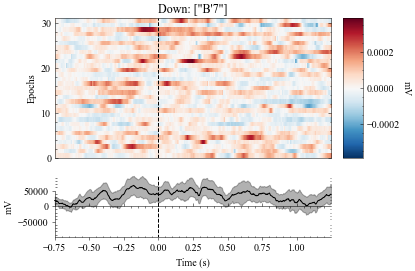

Not setting metadata
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


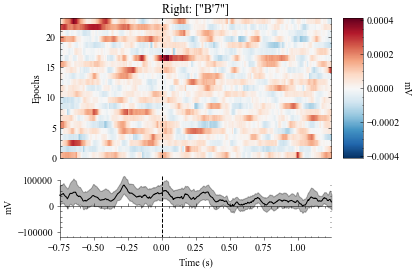

Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


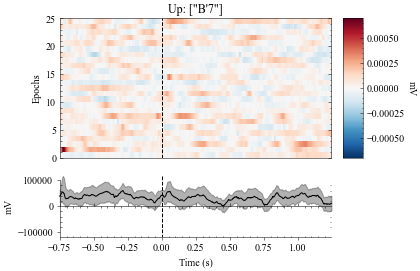

Not setting metadata
Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


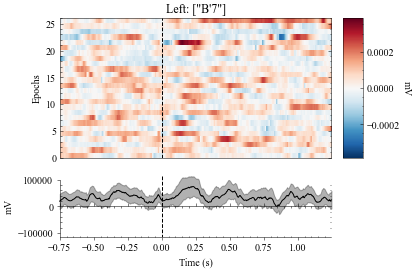

In [9]:
picks = ["B'7"]
plot_epochs(epochs, labels, picks=picks)

## EFRI06

In [10]:
bids_path.subject = "efri06"
bids_path

BIDSPath(
root: /Volumes/mac/research/data/efri
datatype: ieeg
basename: sub-efri06_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr)

In [11]:
# fetch labels
labels, trial_ids = read_label(bids_path, trial_id=None, label_keyword="target_direction")

# we don't want perturbed trials
behav_tsv, events_tsv = get_trial_info(bids_path)
success_trial_flag = np.array(list(map(int, behav_tsv["successful_trial_flag"])))
success_inds = np.where(success_trial_flag == 1)[0]
force_mag = np.array(behav_tsv['force_magnitude'], np.float64)[success_inds]

# filter out labels for unsuccessful trials
unsuccessful_trial_inds = np.where((np.isnan(labels) | (force_mag > 0)))[0]
labels = np.delete(labels, unsuccessful_trial_inds)

# set time window
# tmin, tmax = (-0.5, 1.0)
tmin, tmax = (-0.75, 1.25)

# get EEG data
picks = []
epochs = read_dataset(
    bids_path,
    tmin=tmin,
    tmax=tmax,
    picks=picks,
    event_key="Left Target",
    notch_filter=True,
)

epochs.drop(unsuccessful_trial_inds)

epochs.load_data()

# Low-pass filter up to sfreq/2
fs = epochs.info["sfreq"]
epochs = epochs.filter(l_freq=None, h_freq=fs / 2 - 1)

# Downsample epochs to 500 Hz
resample_rate = 500
epochs = epochs.resample(resample_rate)

Out of 97 trials, there were 94 successful trials in /Volumes/mac/research/data/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Out of 97 trials, there were 94 successful trials in /Volumes/mac/research/data/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Extracting parameters from /Volumes/mac/research/data/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /Volumes/mac/research/data/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-move_acq-seeg_run-01_events.tsv.
Reading channel info from /Volumes/mac/research/data/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-move_acq-seeg_run-01_channels.tsv.
Out of 97 trials, there were 94 successful trials in /Volumes/mac/research/data/efri/sub-efri06/ses-efri/ieeg/sub-efri06_ses-efri_task-move_acq-seeg_run-01_ieeg.vhdr.
Reading 0 ... 2525999  =      0.000 ...  126

Dropped 64 epochs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 40, 42, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75
Dropped 51 epochs: 0, 1, 2, 4, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 36, 38, 39, 40, 41, 42, 43, 45, 46, 48, 50, 51, 52, 53, 55, 57, 58, 60, 63, 65, 66, 68, 69, 70, 71, 74
Dropped 60 epochs: 0, 1, 3, 4, 5, 6, 8, 9, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 71, 72, 73, 74, 75
Dropped 53 epochs: 0, 2, 3, 5, 6, 7, 10, 11, 12, 14, 15, 16, 20, 22, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 39, 41, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 56, 57, 58, 59, 61, 62, 63, 64, 66, 67, 68, 69, 70, 72, 73, 75


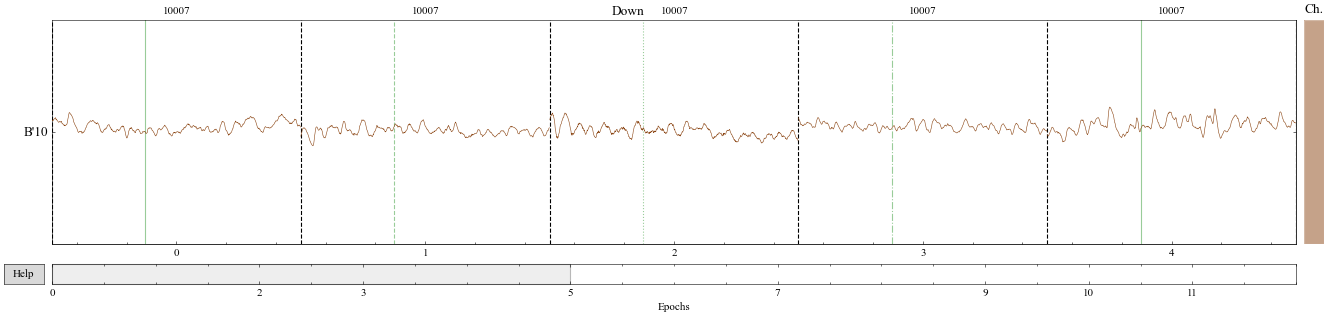

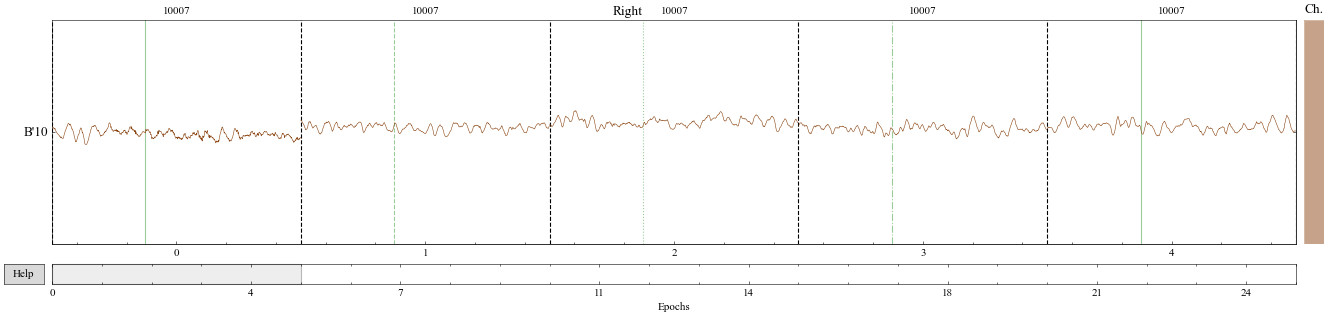

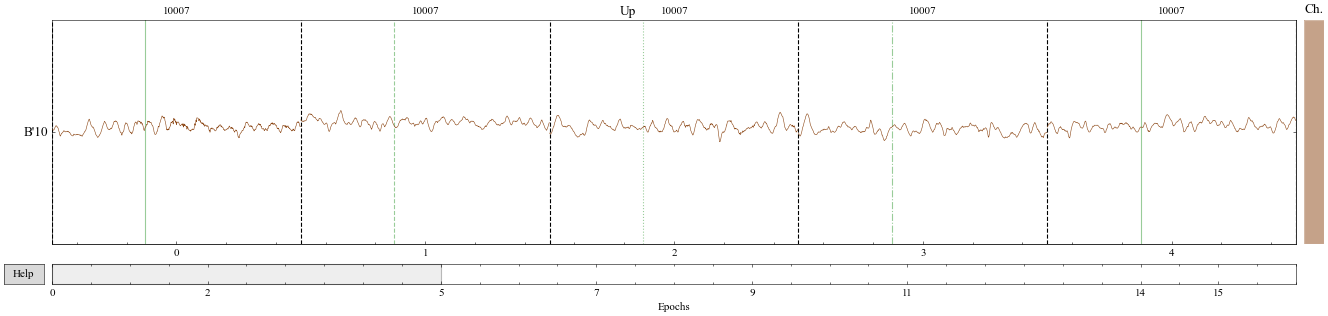

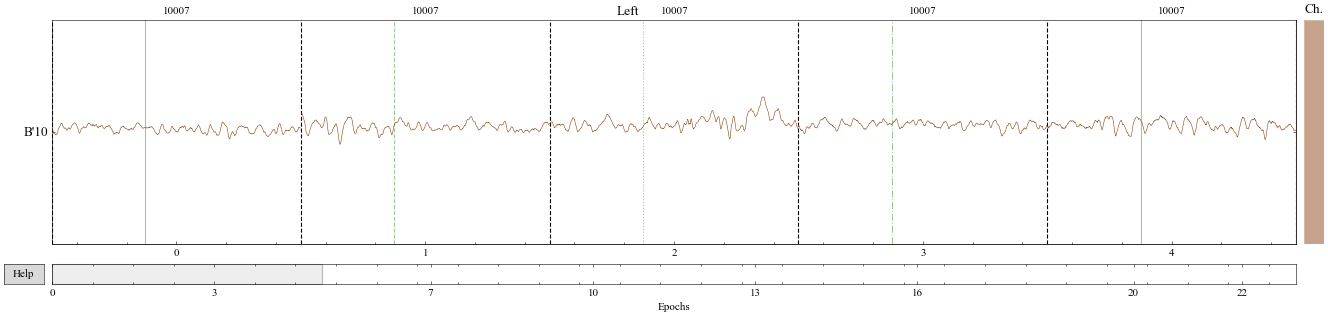

Not setting metadata
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


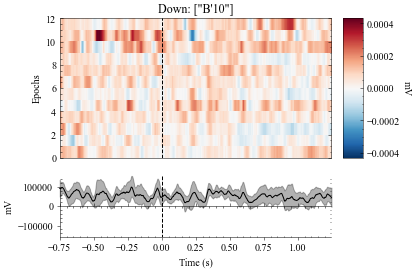

Not setting metadata
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


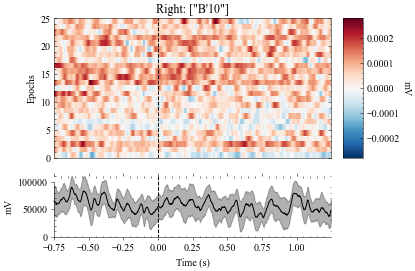

Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


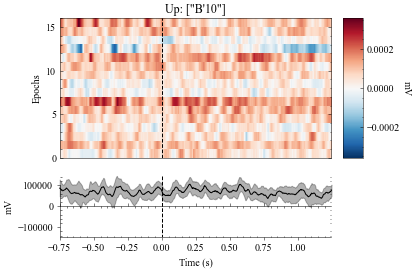

Not setting metadata
Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


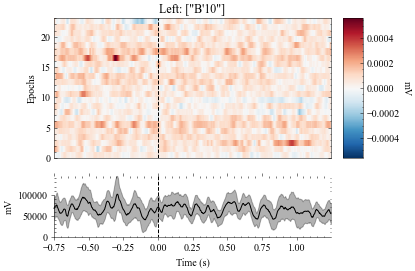

In [16]:
picks = ["B'10"]
plot_epochs(epochs, labels, picks=picks)